/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  This is separate from the ipykernel package so we can avoid doing imports until


            new_cases  new_cases_smoothed
Date                                     
2020-07-01      19160           18790.857
2020-07-02      20903           19306.143
2020-07-03      22771           19908.857
2020-07-04      24850           20615.143
2020-07-05      24248           21299.286
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 335 entries, 2020-07-01 to 2021-05-31
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   new_cases           335 non-null    int64  
 1   new_cases_smoothed  335 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 7.9 KB
None


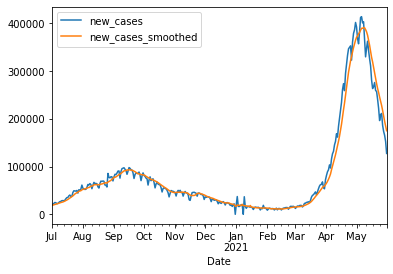

In [1]:
#read csv
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot

def parser(x):
	return datetime.strptime('202'+x, '%Y-%m-%d')
 
series = read_csv('https://raw.githubusercontent.com/ll-cooool-j/DS-Assignment/main/Datasets/Datasets%20for%20ARIMA%20(Only%20Date%20%2B%20Confirmed)/India%20(Date%20%2B%20New%20Cases%20%2B%20Smoothed%20New%20Cases).csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
print(series.head())
print(series.info())
series.plot()
pyplot.show()

#we only use the raw data so we drop the smoothed data attribute out
series = series.drop(columns =['new_cases_smoothed'])

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Observations: 115
Training Observations: 60
Testing Observations: 55
Observations: 170
Training Observations: 115
Testing Observations: 55
Observations: 225
Training Observations: 170
Testing Observations: 55
Observations: 280
Training Observations: 225
Testing Observations: 55
Observations: 335
Training Observations: 280
Testing Observations: 55


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differe

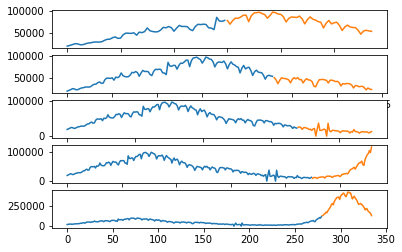

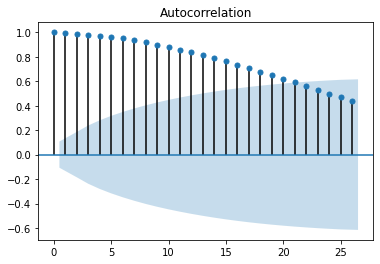

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


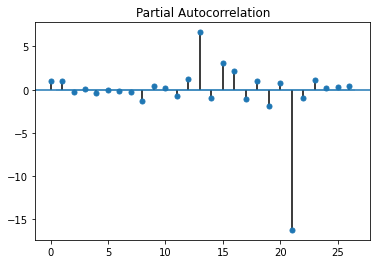

In [2]:
#Implementation of rolling-forward validation train-test split
from sklearn.model_selection import TimeSeriesSplit
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
X = series.values
splits = TimeSeriesSplit(n_splits=5)
pyplot.figure(1)
index = 1
for train_index, test_index in splits.split(X):
	train = X[train_index]
	test = X[test_index]
	print('Observations: %d' % (len(train) + len(test)))
	print('Training Observations: %d' % (len(train)))
	print('Testing Observations: %d' % (len(test)))
	pyplot.subplot(510 + index)
	pyplot.plot(train)
	pyplot.plot([None for i in train] + [x for x in test])
	index += 1
pyplot.show()

#Plot ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(series)
pyplot.show()
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(series)
pyplot.show()

In [3]:
#split dataset into two subsets and calculate the mean
X = series.values
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
print('mean1=%f, mean2=%f' % (mean1, mean2))

mean1=55637.297619, mean2=109236.508982


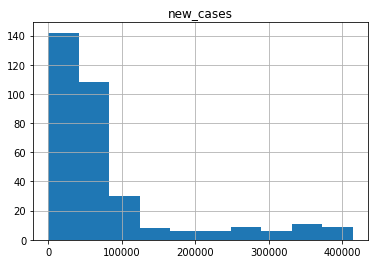

In [4]:
#check distribution of raw data set
series.hist()
pyplot.show()

In [5]:
#define function for ADF test (check stationarity)
import pandas as pd
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#apply adf test on the series
adf_test(series['new_cases'])

Results of Dickey-Fuller Test:
Test Statistic                  -3.473403
p-value                          0.008697
#Lags Used                      14.000000
Number of Observations Used    320.000000
Critical Value (1%)             -3.450952
Critical Value (5%)             -2.870615
Critical Value (10%)            -2.571605
dtype: float64


[0.18165824]


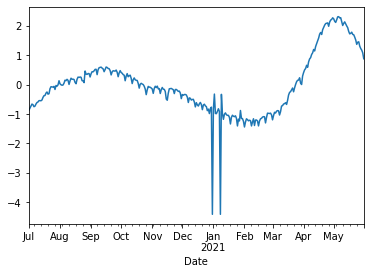

In [6]:
#Power transformation to achieve stationarity as far as possible
import numpy as np
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='yeo-johnson')
pt.fit(series)
print(pt.lambdas_)
series['y'] = pt.transform(series)
series['y'].plot()


In [7]:
#make sure to drop NaN or inf values
series = series.drop(columns = ['new_cases'])
series.dropna(inplace=True)
print(series.head())
print(series.info())

                   y
Date                
2020-07-01 -0.865544
2020-07-02 -0.797658
2020-07-03 -0.729864
2020-07-04 -0.659569
2020-07-05 -0.679413
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 335 entries, 2020-07-01 to 2021-05-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       335 non-null    float64
dtypes: float64(1)
memory usage: 5.2 KB
None


In [8]:
# grid search ARIMA parameters for the whole dataset (with 280 training observations and 55 testing observations)
import warnings
import pandas as pd
from math import sqrt
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
  X = X.astype('float64')
  # prepare training dataset
  train, test = X[:60], X[60:115] 
  history = [x for x in train]

  # make predictions
  predictions = list()
  for t in range(len(test)):
    model = ARIMA(history, order=arima_order)
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test[t])
  # calculate out of sample error
  rmse = sqrt(mean_squared_error(test, predictions))
  return rmse
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
 # load dataset
idx = pd.date_range("2020-07-01", periods=335)
series.index = idx.to_period()
# evaluate parameters
p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 4)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


ARIMA(0, 0, 0) RMSE=0.391
ARIMA(0, 0, 1) RMSE=0.231
ARIMA(0, 0, 2) RMSE=0.162
ARIMA(0, 1, 0) RMSE=0.091
ARIMA(0, 1, 1) RMSE=0.093
ARIMA(0, 1, 2) RMSE=0.089
ARIMA(0, 1, 3) RMSE=0.090
ARIMA(0, 2, 0) RMSE=0.133
ARIMA(1, 0, 0) RMSE=0.088
ARIMA(1, 0, 1) RMSE=0.088
ARIMA(1, 0, 2) RMSE=0.182
ARIMA(1, 0, 3) RMSE=0.150
ARIMA(1, 1, 0) RMSE=0.092
ARIMA(1, 1, 1) RMSE=0.092
ARIMA(1, 1, 2) RMSE=0.090
ARIMA(1, 1, 3) RMSE=0.082
ARIMA(1, 2, 0) RMSE=0.124
ARIMA(2, 0, 0) RMSE=0.088
ARIMA(2, 0, 1) RMSE=2.245
ARIMA(2, 0, 2) RMSE=0.084
ARIMA(2, 1, 0) RMSE=0.087
ARIMA(2, 1, 1) RMSE=0.090
ARIMA(2, 2, 0) RMSE=0.104
Best ARIMA(1, 1, 3) RMSE=0.082


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  334
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -186.556
Method:                           css   S.D. of innovations              0.423
Date:                Sat, 17 Jul 2021   AIC                            377.112
Time:                        02:35:26   BIC                            384.734
Sample:                    07-02-2020   HQIC                           380.151
                         - 05-31-2021                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0052      0.023      0.226      0.821      -0.040       0.051


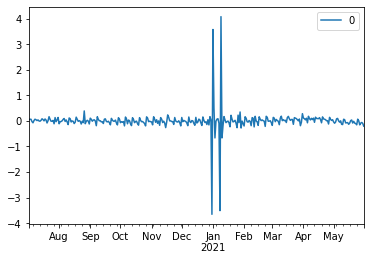

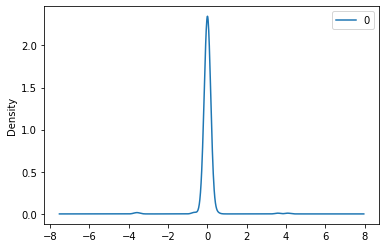

                  0
count  3.340000e+02
mean   8.411455e-09
std    4.236328e-01
min   -3.655442e+00
25%   -6.540390e-02
50%   -1.145154e-03
75%    6.791955e-02
max    4.080740e+00
predicted=0.402318, expected=0.378021
predicted=0.398747, expected=0.263407
predicted=0.281915, expected=0.376047
predicted=0.396072, expected=0.444557
predicted=0.465353, expected=0.438004
predicted=0.458372, expected=0.474921
predicted=0.495543, expected=0.523389
predicted=0.544434, expected=0.525312
predicted=0.546071, expected=0.343116
predicted=0.360891, expected=0.512864
predicted=0.532841, expected=0.579864
predicted=0.600513, expected=0.588665
predicted=0.609147, expected=0.599571
predicted=0.619920, expected=0.565026
predicted=0.584623, expected=0.539573
predicted=0.558561, expected=0.443665
predicted=0.461121, expected=0.517615
predicted=0.535814, expected=0.603019
predicted=0.622091, expected=0.587300
predicted=0.605926, expected=0.553641
predicted=0.571605, expected=0.545526
predicted=0.563164, ex

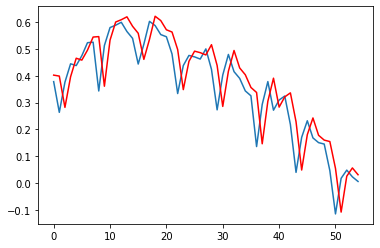

In [13]:
# fit an ARIMA model and plot residual errors
from pandas import DataFrame

# fit model
series = series.astype('float64')
model = ARIMA(series, order=(0,1,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

# evaluate an ARIMA model using a walk-forward validation
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from math import sqrt
import numpy as np
import itertools
from itertools import chain
X = series.values.astype('float64')

# prepare training dataset (60 training observations and 55 testing observations)
train, test = X[:60], X[60:115] 
history = [x for x in train]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(0,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)
mae = mean_absolute_error(test, predictions)
print('MAE score: %.3f' % mae)
r2 = r2_score(test, predictions)
print('R2 score: %.3f' % r2)

# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()


In [9]:
# grid search ARIMA parameters for the whole dataset (with 280 training observations and 55 testing observations)
import warnings
import pandas as pd
from math import sqrt
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
  X = X.astype('float64')
  # prepare training dataset
  train, test = X[:115], X[115:170] 
  history = [x for x in train]

  # make predictions
  predictions = list()
  for t in range(len(test)):
    model = ARIMA(history, order=arima_order)
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test[t])
  # calculate out of sample error
  rmse = sqrt(mean_squared_error(test, predictions))
  return rmse
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
 # load dataset
idx = pd.date_range("2020-07-01", periods=335)
series.index = idx.to_period()
# evaluate parameters
p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 4)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)


ARIMA(0, 0, 0) RMSE=0.376
ARIMA(0, 0, 1) RMSE=0.214
ARIMA(0, 0, 2) RMSE=0.163
ARIMA(0, 1, 0) RMSE=0.105
ARIMA(0, 1, 1) RMSE=0.107
ARIMA(0, 1, 2) RMSE=0.102
ARIMA(0, 1, 3) RMSE=0.103
ARIMA(0, 2, 0) RMSE=0.152
ARIMA(0, 2, 1) RMSE=0.105
ARIMA(1, 0, 0) RMSE=0.104
ARIMA(1, 0, 1) RMSE=0.105
ARIMA(1, 0, 2) RMSE=0.100
ARIMA(1, 0, 3) RMSE=0.101
ARIMA(1, 1, 0) RMSE=0.106
ARIMA(1, 1, 1) RMSE=0.104
ARIMA(1, 1, 2) RMSE=0.103
ARIMA(1, 1, 3) RMSE=0.103
ARIMA(1, 2, 0) RMSE=0.138
ARIMA(2, 0, 0) RMSE=0.105
ARIMA(2, 0, 1) RMSE=0.102
ARIMA(2, 0, 2) RMSE=0.100
ARIMA(2, 0, 3) RMSE=0.103
ARIMA(2, 1, 0) RMSE=0.104
ARIMA(2, 1, 1) RMSE=0.103
ARIMA(2, 1, 2) RMSE=0.097
ARIMA(2, 1, 3) RMSE=0.104
ARIMA(2, 2, 0) RMSE=0.128
ARIMA(2, 2, 2) RMSE=0.103
Best ARIMA(2, 1, 2) RMSE=0.097


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  334
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -186.556
Method:                           css   S.D. of innovations              0.423
Date:                Sat, 17 Jul 2021   AIC                            377.112
Time:                        02:36:17   BIC                            384.734
Sample:                    07-02-2020   HQIC                           380.151
                         - 05-31-2021                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0052      0.023      0.226      0.821      -0.040       0.051


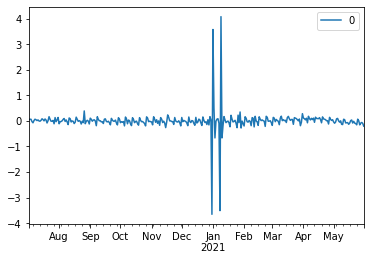

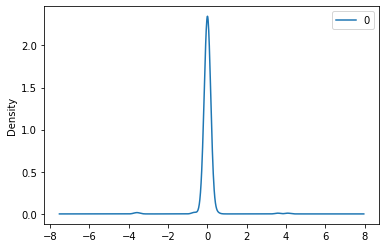

                  0
count  3.340000e+02
mean   8.411455e-09
std    4.236328e-01
min   -3.655442e+00
25%   -6.540390e-02
50%   -1.145154e-03
75%    6.791955e-02
max    4.080740e+00
predicted=0.013077, expected=-0.052608
predicted=-0.045539, expected=-0.148108
predicted=-0.141924, expected=-0.337357
predicted=-0.332842, expected=-0.173525
predicted=-0.167660, expected=-0.057174
predicted=-0.050381, expected=-0.080160
predicted=-0.073615, expected=-0.087340
predicted=-0.080908, expected=-0.112354
predicted=-0.106181, expected=-0.146448
predicted=-0.140602, expected=-0.294366
predicted=-0.289760, expected=-0.126204
predicted=-0.120289, expected=-0.051120
predicted=-0.044656, expected=-0.099346
predicted=-0.093313, expected=-0.048444
predicted=-0.042060, expected=-0.137627
predicted=-0.131985, expected=-0.133095
predicted=-0.127461, expected=-0.299808
predicted=-0.295489, expected=-0.165604
predicted=-0.160302, expected=-0.094242
predicted=-0.088442, expected=-0.153507
predicted=-0.148193, 

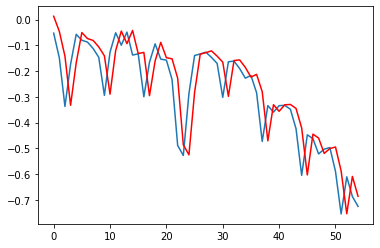

In [14]:
# fit an ARIMA model and plot residual errors
from pandas import DataFrame

# fit model
series = series.astype('float64')
model = ARIMA(series, order=(0,1,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

# evaluate an ARIMA model using a walk-forward validation
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from math import sqrt
import numpy as np
import itertools
from itertools import chain
X = series.values.astype('float64')

# prepare training dataset (115 training observations and 55 testing observations)
train, test = X[:115], X[115:170] 
history = [x for x in train]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(0,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)
mae = mean_absolute_error(test, predictions)
print('MAE score: %.3f' % mae)
r2 = r2_score(test, predictions)
print('R2 score: %.3f' % r2)

# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()


In [10]:
# grid search ARIMA parameters for the whole dataset (with 280 training observations and 55 testing observations)
import warnings
import pandas as pd
from math import sqrt
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
  X = X.astype('float64')
  # prepare training dataset
  train, test = X[:170], X[170:225] 
  history = [x for x in train]

  # make predictions
  predictions = list()
  for t in range(len(test)):
    model = ARIMA(history, order=arima_order)
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test[t])
  # calculate out of sample error
  rmse = sqrt(mean_squared_error(test, predictions))
  return rmse
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
 # load dataset
idx = pd.date_range("2020-07-01", periods=335)
series.index = idx.to_period()
# evaluate parameters
p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 4)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=1.180
ARIMA(0, 0, 1) RMSE=1.090
ARIMA(0, 0, 2) RMSE=1.188
ARIMA(0, 1, 0) RMSE=1.022
ARIMA(0, 1, 1) RMSE=0.772
ARIMA(0, 2, 0) RMSE=1.770
ARIMA(0, 2, 1) RMSE=1.028
ARIMA(1, 0, 0) RMSE=0.999
ARIMA(1, 1, 0) RMSE=1.043
ARIMA(1, 2, 0) RMSE=1.573
ARIMA(2, 0, 0) RMSE=1.018
ARIMA(2, 1, 0) RMSE=0.970
Best ARIMA(0, 1, 1) RMSE=0.772


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  334
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -186.556
Method:                           css   S.D. of innovations              0.423
Date:                Sat, 17 Jul 2021   AIC                            377.112
Time:                        02:36:43   BIC                            384.734
Sample:                    07-02-2020   HQIC                           380.151
                         - 05-31-2021                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0052      0.023      0.226      0.821      -0.040       0.051


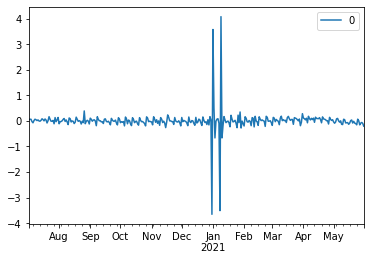

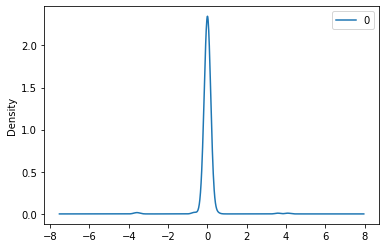

                  0
count  3.340000e+02
mean   8.411455e-09
std    4.236328e-01
min   -3.655442e+00
25%   -6.540390e-02
50%   -1.145154e-03
75%    6.791955e-02
max    4.080740e+00
predicted=-0.724874, expected=-0.649762
predicted=-0.648493, expected=-0.603297
predicted=-0.601763, expected=-0.676454
predicted=-0.675355, expected=-0.849690
predicted=-0.849598, expected=-0.689386
predicted=-0.688373, expected=-0.664083
predicted=-0.662932, expected=-0.719543
predicted=-0.718714, expected=-0.747479
predicted=-0.746812, expected=-0.882984
predicted=-0.883082, expected=-0.831405
predicted=-0.831215, expected=-0.982713
predicted=-0.983364, expected=-0.811060
predicted=-0.810759, expected=-0.763712
predicted=-0.763152, expected=-4.413913
predicted=-4.433303, expected=-0.830860
predicted=-0.830672, expected=-0.318780
predicted=-0.315824, expected=-0.979423
predicted=-0.980035, expected=-0.985327
predicted=-0.985967, expected=-0.909850
predicted=-0.910085, expected=-0.818831
predicted=-0.818584,

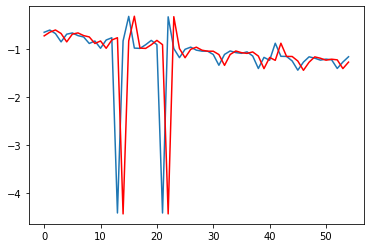

In [15]:
# fit an ARIMA model and plot residual errors
from pandas import DataFrame

# fit model
series = series.astype('float64')
model = ARIMA(series, order=(0,1,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

# evaluate an ARIMA model using a walk-forward validation
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from math import sqrt
import numpy as np
import itertools
from itertools import chain
X = series.values.astype('float64')

# prepare training dataset (170 training observations and 55 testing observations)
train, test = X[0:170], X[170:225] 
history = [x for x in train]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(0,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)
mae = mean_absolute_error(test, predictions)
print('MAE score: %.3f' % mae)
r2 = r2_score(test, predictions)
print('R2 score: %.3f' % r2)

# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()


In [11]:
# grid search ARIMA parameters for the whole dataset (with 280 training observations and 55 testing observations)
import warnings
import pandas as pd
from math import sqrt
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
  X = X.astype('float64')
  # prepare training dataset
  train, test = X[:225], X[225:280] 
  history = [x for x in train]

  # make predictions
  predictions = list()
  for t in range(len(test)):
    model = ARIMA(history, order=arima_order)
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test[t])
  # calculate out of sample error
  rmse = sqrt(mean_squared_error(test, predictions))
  return rmse
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
 # load dataset
idx = pd.date_range("2020-07-01", periods=335)
series.index = idx.to_period()
# evaluate parameters
p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 4)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=0.663
ARIMA(0, 0, 1) RMSE=0.447
ARIMA(0, 0, 2) RMSE=0.365
ARIMA(0, 0, 3) RMSE=0.342
ARIMA(0, 1, 0) RMSE=0.115
ARIMA(0, 1, 1) RMSE=0.215
ARIMA(0, 2, 0) RMSE=0.164
ARIMA(0, 2, 1) RMSE=0.117
ARIMA(1, 0, 0) RMSE=0.207
ARIMA(1, 0, 1) RMSE=0.218
ARIMA(1, 0, 2) RMSE=0.222
ARIMA(1, 0, 3) RMSE=0.228
ARIMA(1, 1, 0) RMSE=0.125
ARIMA(1, 1, 1) RMSE=0.217
ARIMA(1, 1, 2) RMSE=0.187
ARIMA(1, 1, 3) RMSE=0.188
ARIMA(1, 2, 0) RMSE=0.151
ARIMA(1, 2, 3) RMSE=0.182
ARIMA(2, 0, 0) RMSE=0.161
ARIMA(2, 0, 1) RMSE=0.220
ARIMA(2, 0, 3) RMSE=0.193
ARIMA(2, 1, 0) RMSE=0.139
ARIMA(2, 1, 1) RMSE=0.218
ARIMA(2, 1, 2) RMSE=0.188
ARIMA(2, 2, 0) RMSE=0.138
Best ARIMA(0, 1, 0) RMSE=0.115


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  334
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -186.556
Method:                           css   S.D. of innovations              0.423
Date:                Sat, 17 Jul 2021   AIC                            377.112
Time:                        02:36:52   BIC                            384.734
Sample:                    07-02-2020   HQIC                           380.151
                         - 05-31-2021                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0052      0.023      0.226      0.821      -0.040       0.051


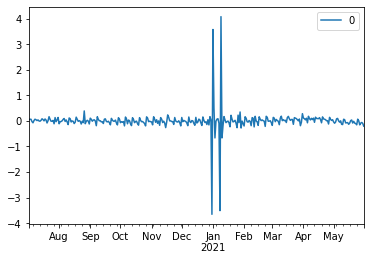

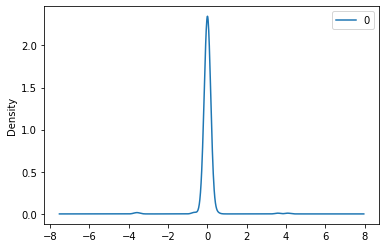

                  0
count  3.340000e+02
mean   8.411455e-09
std    4.236328e-01
min   -3.655442e+00
25%   -6.540390e-02
50%   -1.145154e-03
75%    6.791955e-02
max    4.080740e+00
predicted=-1.160847, expected=-1.388851
predicted=-1.391177, expected=-1.204113
predicted=-1.205612, expected=-1.201128
predicted=-1.202607, expected=-1.233574
predicted=-1.235188, expected=-1.402668
predicted=-1.405013, expected=-1.235943
predicted=-1.237554, expected=-1.161878
predicted=-1.163161, expected=-1.144616
predicted=-1.145819, expected=-1.101833
predicted=-1.102848, expected=-1.087795
predicted=-1.088744, expected=-1.091142
predicted=-1.092102, expected=-1.300741
predicted=-1.302585, expected=-1.115036
predicted=-1.116089, expected=-0.968810
predicted=-0.969244, expected=-0.976099
predicted=-0.976562, expected=-0.980153
predicted=-0.980631, expected=-0.968179
predicted=-0.968605, expected=-1.025926
predicted=-1.026589, expected=-1.195769
predicted=-1.197128, expected=-1.051282
predicted=-1.052043,

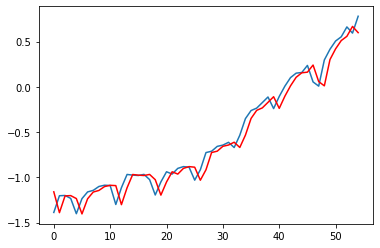

In [16]:
# fit an ARIMA model and plot residual errors
from pandas import DataFrame

# fit model
series = series.astype('float64')
model = ARIMA(series, order=(0,1,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

# evaluate an ARIMA model using a walk-forward validation
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from math import sqrt
import numpy as np
import itertools
from itertools import chain
X = series.values.astype('float64')

# prepare training dataset (225 training observations and 55 testing observations)
train, test = X[:225], X[225:280] 
history = [x for x in train]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(0,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)
mae = mean_absolute_error(test, predictions)
print('MAE score: %.3f' % mae)
r2 = r2_score(test, predictions)
print('R2 score: %.3f' % r2)

# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()


In [12]:
# grid search ARIMA parameters for the whole dataset (with 280 training observations and 55 testing observations)
import warnings
import pandas as pd
from math import sqrt
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
  X = X.astype('float64')
  # prepare training dataset
  train, test = X[:280], X[280:] 
  history = [x for x in train]

  # make predictions
  predictions = list()
  for t in range(len(test)):
    model = ARIMA(history, order=arima_order)
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test[t])
  # calculate out of sample error
  rmse = sqrt(mean_squared_error(test, predictions))
  return rmse
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
 # load dataset
idx = pd.date_range("2020-07-01", periods=335)
series.index = idx.to_period()
# evaluate parameters
p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 4)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=1.963
ARIMA(0, 0, 1) RMSE=1.217
ARIMA(0, 0, 2) RMSE=0.902
ARIMA(0, 0, 3) RMSE=0.800
ARIMA(0, 1, 0) RMSE=0.090
ARIMA(0, 1, 1) RMSE=0.227
ARIMA(0, 2, 0) RMSE=0.098
ARIMA(0, 2, 1) RMSE=0.091
ARIMA(1, 0, 0) RMSE=0.302
ARIMA(1, 0, 1) RMSE=0.234
ARIMA(1, 0, 2) RMSE=0.233
ARIMA(1, 0, 3) RMSE=0.231
ARIMA(1, 1, 0) RMSE=0.114
ARIMA(1, 1, 1) RMSE=0.227
ARIMA(1, 1, 2) RMSE=0.170
ARIMA(1, 1, 3) RMSE=0.174
ARIMA(1, 2, 0) RMSE=0.096
ARIMA(1, 2, 3) RMSE=0.176
ARIMA(2, 0, 0) RMSE=0.198
ARIMA(2, 0, 1) RMSE=24059.450
ARIMA(2, 0, 2) RMSE=0.167
ARIMA(2, 0, 3) RMSE=0.171
ARIMA(2, 1, 0) RMSE=0.141
ARIMA(2, 1, 1) RMSE=0.225
ARIMA(2, 1, 2) RMSE=0.173
ARIMA(2, 1, 3) RMSE=0.171
ARIMA(2, 2, 0) RMSE=0.094
Best ARIMA(0, 1, 0) RMSE=0.090


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  334
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -186.556
Method:                           css   S.D. of innovations              0.423
Date:                Sat, 17 Jul 2021   AIC                            377.112
Time:                        02:36:59   BIC                            384.734
Sample:                    07-02-2020   HQIC                           380.151
                         - 05-31-2021                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0052      0.023      0.226      0.821      -0.040       0.051


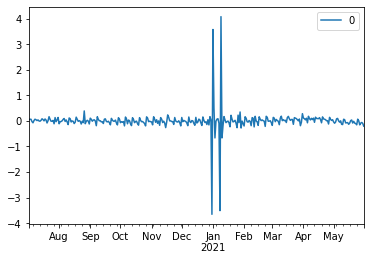

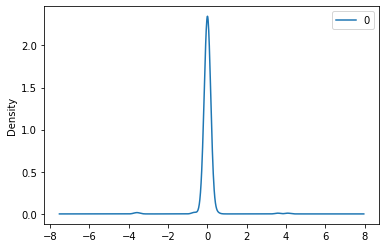

                  0
count  3.340000e+02
mean   8.411455e-09
std    4.236328e-01
min   -3.655442e+00
25%   -6.540390e-02
50%   -1.145154e-03
75%    6.791955e-02
max    4.080740e+00
predicted=0.785775, expected=0.878516
predicted=0.884744, expected=0.922329
predicted=0.928692, expected=1.029612
predicted=1.036332, expected=1.086061
predicted=1.092958, expected=1.199594
predicted=1.206865, expected=1.149921
predicted=1.156993, expected=1.301001
predicted=1.308576, expected=1.401038
predicted=1.408936, expected=1.495976
predicted=1.504175, expected=1.588921
predicted=1.597414, expected=1.721617
predicted=1.730539, expected=1.779533
predicted=1.788622, expected=1.710985
predicted=1.719809, expected=1.874367
predicted=1.883718, expected=1.956117
predicted=1.965714, expected=2.029111
predicted=2.038924, expected=2.082328
predicted=2.092287, expected=2.093257
predicted=2.103219, expected=2.105582
predicted=2.115552, expected=1.990000
predicted=1.999550, expected=2.134840
predicted=2.144841, ex

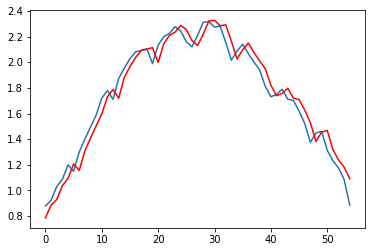

In [17]:
# fit an ARIMA model and plot residual errors
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
# fit model
series = series.astype('float64')
model = ARIMA(series, order=(0,1,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

# evaluate an ARIMA model using a walk-forward validation
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from math import sqrt
import numpy as np
import itertools
from itertools import chain
X = series.values.astype('float64')

# prepare training dataset (280 training observations and 55 testing observations)
train, test = X[:280], X[280:] 
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(0,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)
mae = mean_absolute_error(test, predictions)
print('MAE score: %.3f' % mae)
r2 = r2_score(test, predictions)
print('R2 score: %.3f' % r2)

# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()


                   y
2020-07-01 -0.865544
2020-07-02 -0.797658
2020-07-03 -0.729864
2020-07-04 -0.659569
2020-07-05 -0.679413
...              ...
2021-05-27  1.313556
2021-05-28  1.232382
2021-05-29  1.176562
2021-05-30  1.084991
2021-05-31  0.884702

[335 rows x 1 columns]


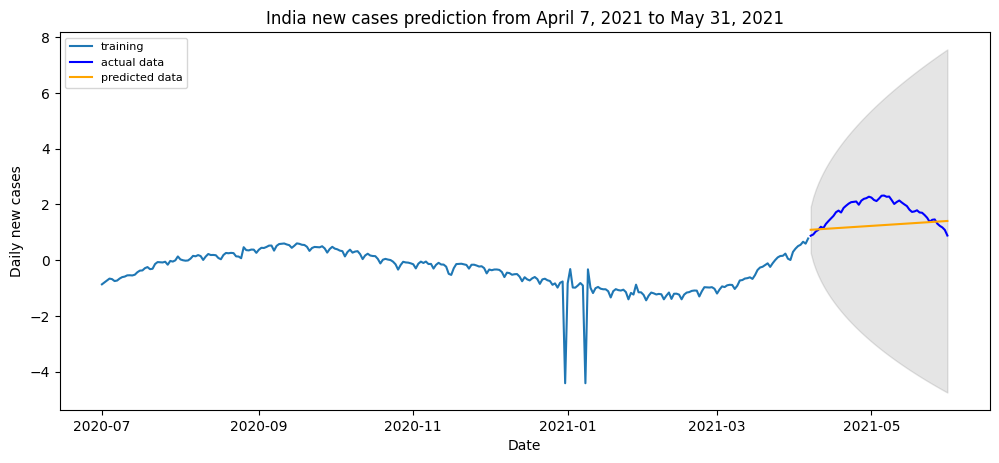

In [18]:
import pandas as pd
from statsmodels.tsa.stattools import acf 
import matplotlib.pyplot as plt
from scipy.special import inv_boxcox

print(series)
train1 = series.iloc[0:280]
idx1 = pd.date_range("2020-07-01", periods=280)
train1.index = idx1

test1 = series.iloc[280:]
idx2 = pd.date_range("2021-04-07", periods=55)
test1.index = idx2


# Forecast
fc, se, conf = model_fit.forecast(55, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test1.index)
lower_series = pd.Series(conf[:, 0], index=test1.index)
upper_series = pd.Series(conf[:, 1], index=test1.index)
fig = plt.figure(figsize=(12,5), dpi=100)
plt.plot(train1, label='training')
plt.plot(test1, color = 'blue', label='actual data')
plt.plot(fc_series, color = 'orange',label='predicted data')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('India new cases prediction from April 7, 2021 to May 31, 2021')
plt.xlabel('Date')
plt.ylabel('Daily new cases')
plt.legend(loc='upper left', fontsize=8)
plt.show()
